In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from datetime import datetime, timezone, timedelta

In [3]:
# Load and prepare the data
microsoft = pd.read_csv("Dataset.csv")
microsoft['date'] = pd.to_datetime(microsoft['date'], utc=True)
microsoft = microsoft.sort_values('date')

In [4]:
# Use only the 'close' column for prediction
data = microsoft.filter(['close'])
dataset = data.values
training = int(np.ceil(0.8 * len(dataset)))

In [5]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [6]:
# Create training data
train_data = scaled_data[0:training, :]
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [20]:
# Build the LSTM model
model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1], 1)),
    keras.layers.LSTM(units=64, return_sequences=True),
    keras.layers.LSTM(units=64),
    keras.layers.Dense(128),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
7815/7815 ━━━━━━━━━━━━━━━━━━━━ 115s 14ms/step - loss: 2.2671e-04
Epoch 2/3
7815/7815 ━━━━━━━━━━━━━━━━━━━━ 136s 17ms/step - loss: 5.8326e-05
Epoch 3/3
7815/7815 ━━━━━━━━━━━━━━━━━━━━ 126s 16ms/step - loss: 4.6301e-05


In [22]:
# Create testing data
X_test = []
test_data = scaled_data[training - 60:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [23]:
# Prepare test DataFrame
actual_prices = dataset[training:]
test = microsoft[training:].copy()
test['Predictions'] = pred

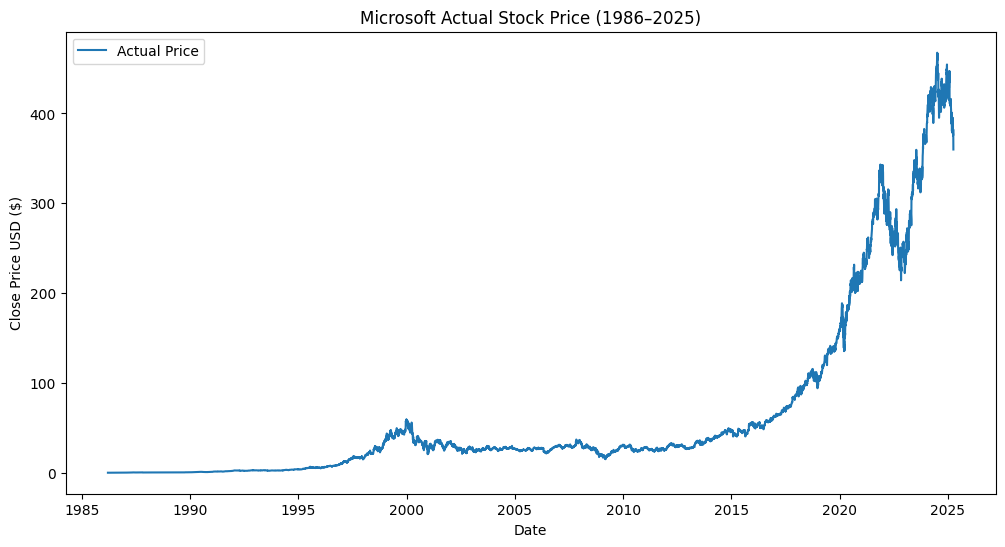

In [24]:
# Plot full actual stock price history
plt.figure(figsize=(12,6))
plt.title('Microsoft Actual Stock Price (1986–2025)')
plt.plot(microsoft['date'], microsoft['close'], label='Actual Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

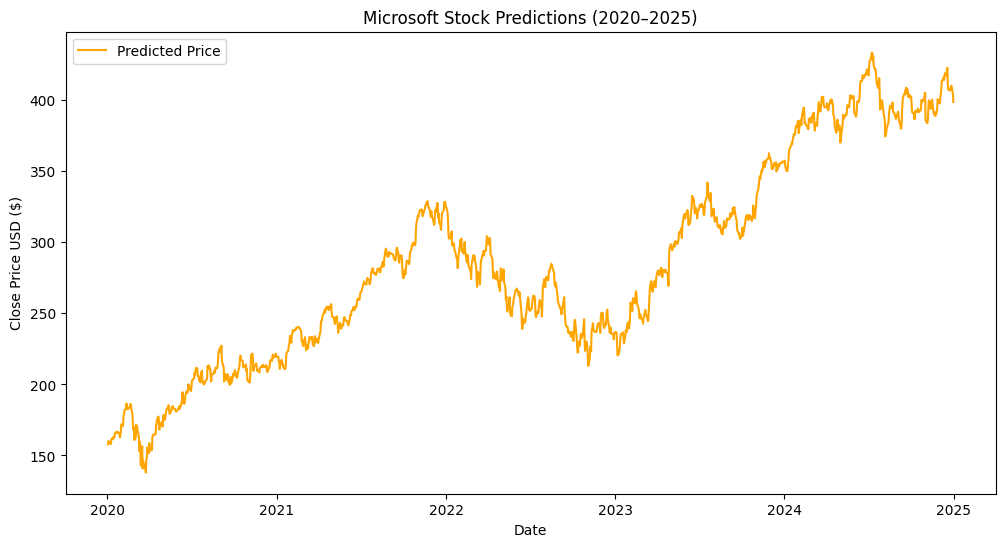

In [25]:
# Plot predictions from 2020 to 2025
prediction_period = test[(test['date'] >= datetime(2020, 1, 1, tzinfo=timezone.utc)) &
                         (test['date'] <= datetime(2025, 1, 1, tzinfo=timezone.utc))]

plt.figure(figsize=(12,6))
plt.title('Microsoft Stock Predictions (2020–2025)')
plt.plot(prediction_period['date'], prediction_period['Predictions'], label='Predicted Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

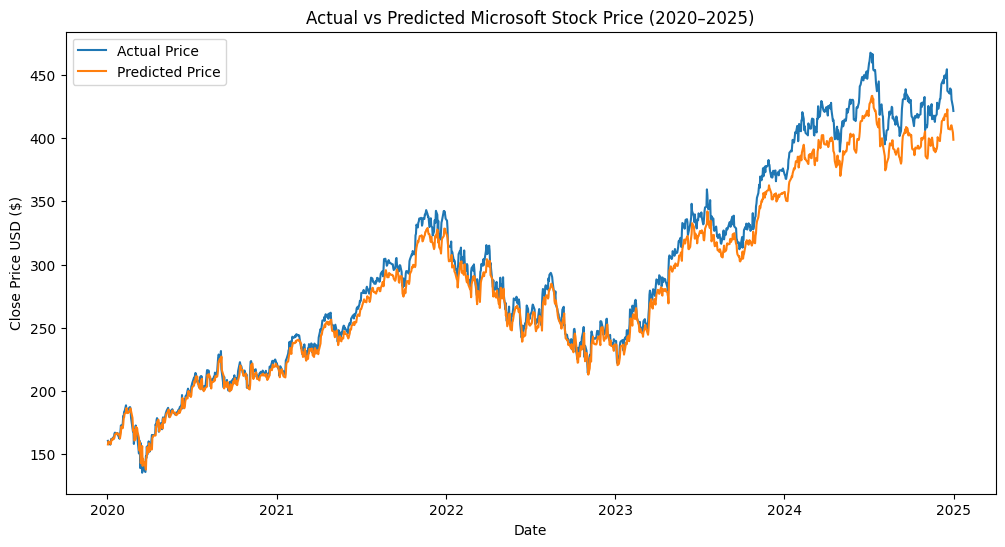

Root Mean Squared Error (2020–2025): 14.41
Error Percentage (2020–2025): 4.90%
Forecasting complete.


In [40]:
# Plot comparison of actual vs predicted values (2020–2025)
plt.figure(figsize=(12,6))
plt.title('Actual vs Predicted Microsoft Stock Price (2020–2025)')
plt.plot(prediction_period['date'], prediction_period['close'], label='Actual Price')
plt.plot(prediction_period['date'], prediction_period['Predictions'], label='Predicted Price', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

# Calculate and print error rate (RMSE and percentage error)
rmse = np.sqrt(mean_squared_error(prediction_period['close'], prediction_period['Predictions']))
mean_actual = prediction_period['close'].mean()
error_percent = (rmse / mean_actual) * 100
print(f"Root Mean Squared Error (2020–2025): {rmse:.2f}")
print(f"Error Percentage (2020–2025): {error_percent:.2f}%")

print("Forecasting complete.")